In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
nltk.download('stopwords')

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import os
import sys
import glob
import pandas as pd

from collections import Counter
from numpy import array as _A
from timeit import default_timer

import common_utils

config = common_utils.get_config()
STOP_WORDS = nltk.corpus.stopwords.words()
print("STOP_WORDS", STOP_WORDS[:10])

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to /home/ishay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
STOP_WORDS ['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي']


/home/ishay/projects/Gun/VENV/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import glob
X_train_file_name = list()
X_test_file_name = list()
Y_train = list()
Y_test = list()
labels = config['labels']
modes = ('train','test')

counters ={mode:{label:0 for label in labels} for mode in modes }

for mode, paths, x, y in zip(
    modes, 
    (config['train_folders'], config['test_folders']), 
    (X_train_file_name, X_test_file_name),
    (Y_train, Y_test)):
    
    for path_name in paths:
        the_label = path_name.split('/')[-2]
        files_list = list(glob.iglob(path_name+"/*.txt"))
        # print ("Mode %s, Found %d for %s"%(mode, len(files_list), path_name))
        x.extend(files_list)
        y.extend([the_label==labels[0]]*len(files_list))
        
        counters[mode][the_label] += len(files_list)
        

Y_test = _A(Y_test)
Y_train = _A(Y_train)

print("X_train_sentences", len(X_train_file_name), "X_test_sentences", len(X_test_file_name))    
print("Y_train_sentences", len(Y_train), "Y_test_sentences", len(Y_test))    
print("counters", counters)    


X_train_sentences 28082 X_test_sentences 11887
Y_train_sentences 28082 Y_test_sentences 11887
counters {'test': {'conservative': 4549, 'liberal': 7338}, 'train': {'conservative': 12515, 'liberal': 15567}}


In [3]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower().strip()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data


def process_single_file(full_path):
    #txt = list()
    lines = open(full_path, 'rt').readlines()
    regex = re.compile('([^\s\w]|_)+')

    word_counter = Counter()
    label = full_path.split('/')[-3]

    words_lists_lists = list()
    for line in lines:
        line_split = regex.sub('', line).lower().strip().split()
        words_lists_lists.append(line_split)
        word_counter.update(line_split)  

    if 0:
        num_skipped = 0 
        header = words_lists_lists.pop(0) # Extract header
        for line in lines:
            skip = False
            for ignore_word in ignore_words:
                if ignore_word in line:
                    skip = True
                    break
            if skip:
                num_skipped +=1 
            else:
                #txt.append(line)
                for word in line.split():
                    word = word.strip()
                    if word not in trival_words:
                        word_counter.update([word])
                        
    
    return word_counter, label, full_path, words_lists_lists
    

#Test a single file
full_path = X_train_file_name[0]
word_counter, label, full_path, words_lists_lists = process_single_file(full_path)
#print('valid %d, skipped %d, concatnated %d, total sum words %d'%(len(txt), num_skipped, len(concated_txt), total_num_words))
total_num_words = sum([a for a in word_counter.values()])
print('Per single file: total %d number of words, total sum words %d'%(len(word_counter), total_num_words))
print(len(words_lists_lists), len(words_lists_lists[0]))
print(word_counter.most_common(30))

Per single file: total 57 number of words, total sum words 74
4 29
[('the', 3), ('tim', 3), ('and', 3), ('of', 3), ('media', 3), ('graham', 3), ('news', 2), ('all', 2), ('how', 2), ('is', 2), ('fox', 2), ('doing', 1), ('rights', 1), ('to', 1), ('material', 1), ('network', 1), ('llc', 1), ('centers', 1), ('stop', 1), ('read', 1), ('delayed', 1), ('with', 1), ('20', 1), ('newsbusters', 1), ('collusion', 1), ('be', 1), ('bozell', 1), ('research', 1), ('coauthor', 1), ('may', 1)]


In [4]:
#Proces all files

X_train_docs_list = list()

start_time = default_timer()
for i, full_path in enumerate(X_train_file_name):
    word_counter, label, full_path, words_lists_lists = process_single_file(full_path)
    X_train_docs_list.append(words_lists_lists)
    
    if i%10000==1:
        runtime = default_timer()-start_time
        print("processed %d, %d seconds, AVG %dms"%(i, runtime, 1000*runtime/i))

runtime = default_timer() - start_time
print("finished processing %d train txt files, %d seconds, AVG %.2fms"%(len(X_train_docs_list), runtime, 1000*runtime/i))

X_test_docs_list = list()

start_time = default_timer()
for i, full_path in enumerate(X_test_file_name):
    word_counter, label, full_path, words_lists_lists = process_single_file(full_path)
    X_test_docs_list.append(words_lists_lists)
    
    if i%10000==1:
        runtime = default_timer()-start_time
        print("processed %d, %d seconds, AVG %dms"%(i, runtime, 1000*runtime/i))

runtime = default_timer() - start_time
print("finished processing %d test txt files, %d seconds, AVG %.2fms"%(len(X_test_docs_list), runtime, 1000*runtime/i))



processed 1, 0 seconds, AVG 0ms
processed 10001, 5 seconds, AVG 0ms
processed 20001, 12 seconds, AVG 0ms
finished processing 28082 train txt files, 15 seconds, AVG 0.56ms
processed 1, 0 seconds, AVG 1ms
processed 1001, 0 seconds, AVG 0ms
processed 2001, 0 seconds, AVG 0ms
processed 3001, 1 seconds, AVG 0ms
processed 4001, 1 seconds, AVG 0ms
processed 5001, 1 seconds, AVG 0ms
processed 6001, 2 seconds, AVG 0ms
processed 7001, 3 seconds, AVG 0ms
processed 8001, 3 seconds, AVG 0ms
processed 9001, 4 seconds, AVG 0ms
processed 10001, 5 seconds, AVG 0ms
processed 11001, 5 seconds, AVG 0ms
finished processing 11887 test txt files, 6 seconds, AVG 0.55ms


In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
vector_sizes = [128,256,512, 1024]

X_train_documents = [TaggedDocument([word for line in doc for word in line], [i]) for i, doc in enumerate(X_train_docs_list)]
models = list()

for vector_size in vector_sizes:
    start_time = default_timer()
    model = Doc2Vec(X_train_documents, vector_size=vector_size, window=2, min_count=3, workers=6)
    runtime = default_timer()-start_time

    print("Done doc2vec on %d docs with vector size %d, runtime %d seconds, AVG %dms"%(
    len(X_train_documents), vector_size, runtime, 1000.*runtime/(len(X_train_documents))))
    models.append(model)


Done doc2vec on 28082 docs with vector size 128, runtime 54 seconds, AVG 1ms
Done doc2vec on 28082 docs with vector size 256, runtime 66 seconds, AVG 2ms
Done doc2vec on 28082 docs with vector size 512, runtime 89 seconds, AVG 3ms
Done doc2vec on 28082 docs with vector size 1024, runtime 143 seconds, AVG 5ms


In [6]:
# Compute mean vectors per vector size per label


X_train_flat_docs = [[word for line in doc for word in line] for doc in X_train_docs_list]

D  ={label:dict({"means":dict()}) for label in labels+['total']}

for model in models:
    vector_size = model.vector_size
    means_vectores = np.zeros( (len(labels), model.vector_size), dtype=np.float32)
    count_per_label = np.zeros(len(labels), dtype=np.float32)
    
    start_time = default_timer()
    for doc, label_index in zip(X_train_flat_docs, Y_train):
        vec = model.infer_vector(doc)
        means_vectores[int(label_index)] += vec
        count_per_label[int(label_index)] += 1

    means_vectores = means_vectores / count_per_label.reshape(len(labels),1)
    D[labels[int(label_index)]]['means'][vector_size] = means_vectores
    
    runtime = default_timer()-start_time
    print("Done calc X train vectors in %d seconds for len %d"%(runtime, model.vector_size), len(X_train_flat_docs))
    #imshow(X_test_vectors, aspect='auto');
    #title('Test data Features');
print ("Done calculating means per vector per label")


Done calc X train vectors in 118 seconds for len 128 28082
Done calc X train vectors in 164 seconds for len 256 28082
Done calc X train vectors in 238 seconds for len 512 28082
Done calc X train vectors in 373 seconds for len 1024 28082
Done calculating means per vector per label


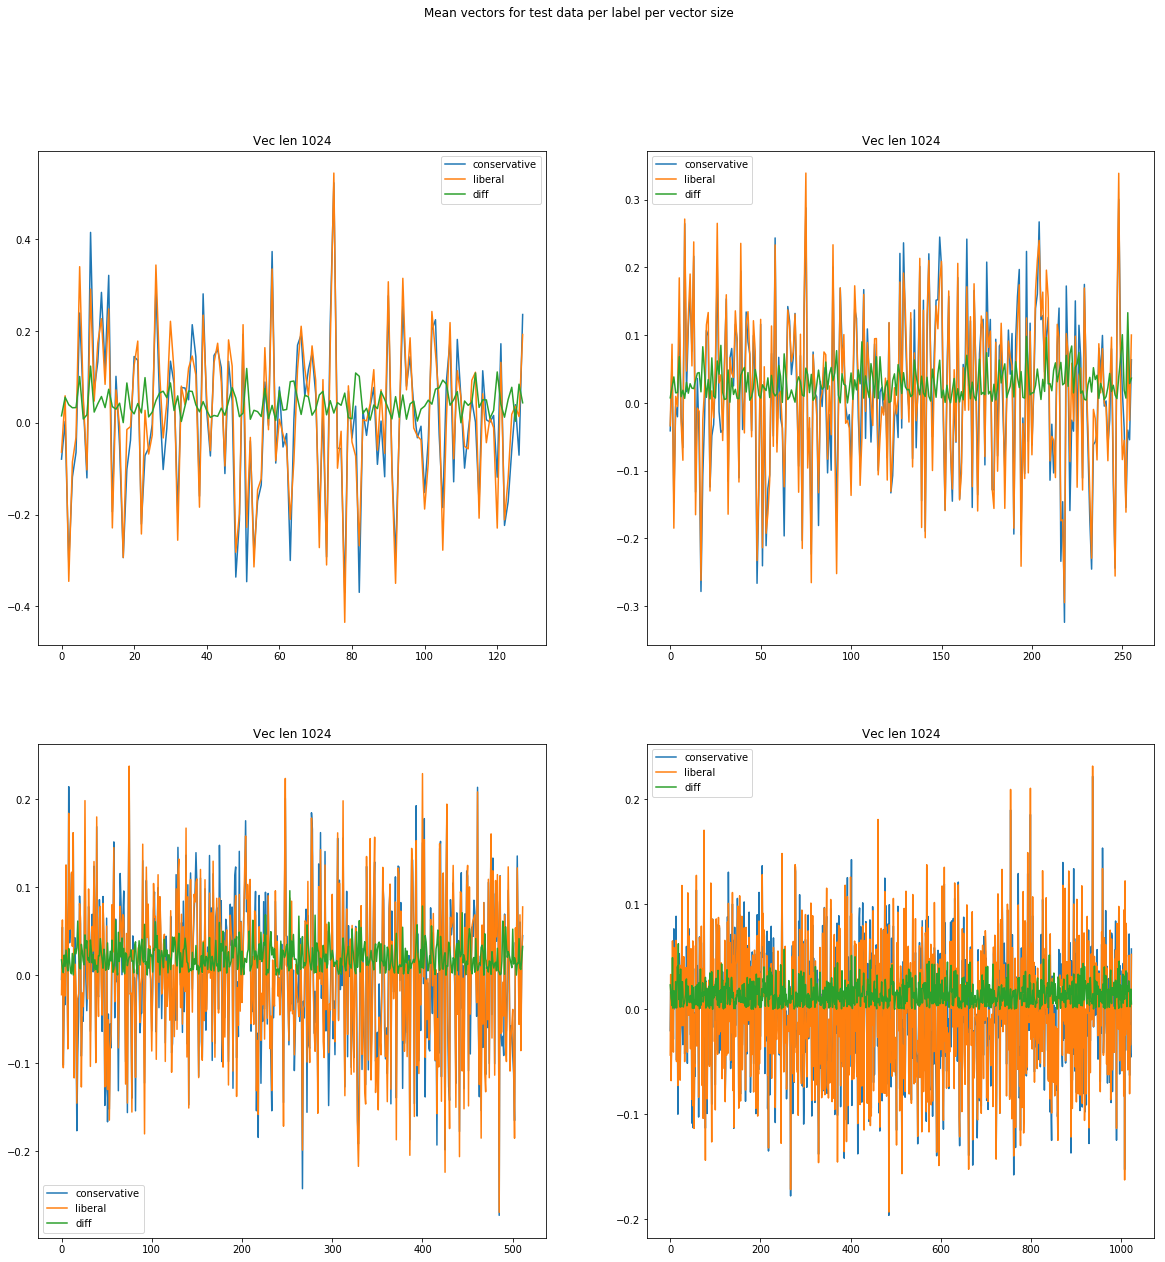

In [7]:
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

fig, ax = plt.subplots(2,2)
ax = [axis for row in ax for axis in row] # Flatten
for axis, model in zip(ax, models):
    mn_ = D[labels[0]]['means'][model.vector_size]
    axis.plot(mn_[0], label=labels[0])
    axis.plot(mn_[1], label=labels[1])
    dff = np.abs(mn_[0]-mn_[1])
    axis.plot(dff, label='diff')
    axis.legend();
    axis.set_title('Vec len %d'%vector_size);
    
fig.suptitle('Mean vectors for test data per label per vector size');


In [8]:
def calc_accuracy_by_distance(v, means, ground_truth):
    ''' Calculate argmin to nearest vector '''
    err0 = np.mean(np.abs(v-means[0]), axis=1) # Batch error from mean vector of label 0
    err1 = np.mean(np.abs(v-means[1]), axis=1) # Batch error from mean vector of label 1
    prediction = np.argmin([err0, err1], axis=0) # Choose best vector index per entry in batch.
    argmn_err = np.mean(np.abs(prediction-ground_truth)) # Calc error 
    return 1.-argmn_err # Return accuracy
     

X_test_flat_docs = [[word for line in doc for word in line] for doc in X_test_docs_list]

accuracies_by_distance_per_vec_size = {}


for model in models:
    start_time = default_timer()
    mn_ = D[labels[0]]['means'][model.vector_size]
    vecs = _A([model.infer_vector(doc) for doc in X_test_flat_docs])
    accuracy = calc_accuracy_by_distance(vecs, mn_, _A(Y_test, dtype=np.float32))
    runtime = default_timer()-start_time
    print("vec size %d, accuracy %.5f, runtime %d seconds"%(model.vector_size, accuracy, runtime))
    accuracies_by_distance_per_vec_size[model.vector_size]=accuracy


vec size 128, accuracy 0.57794, runtime 55 seconds
vec size 256, accuracy 0.58459, runtime 77 seconds
vec size 512, accuracy 0.59906, runtime 113 seconds
vec size 1024, accuracy 0.59519, runtime 177 seconds


In [45]:
import sklearn
from multiprocess import Pool
pool = Pool(4)
all_start_time = default_timer()

def calc_fetures_train(model):
    start_time = default_timer()
    #model, flat_list = model_and_flat_list
    ret =  _A([model.infer_vector(doc) for doc in X_train_flat_docs])
    runtime = default_timer()-start_time
    print("Done train calc_fetures for size %d after %d seconds"%(model.vector_size, runtime))
    return model, ret

train_features_list_fv_size = pool.map(calc_fetures_train, models)
all_runtime = default_timer()-all_start_time
print("Done calculating all Train feature vectors, runtime %d seconds"%(all_runtime))
train_features_per_len ={model.vector_size: vectors for model, vectors in train_features_list_fv_size}


Done train calc_fetures for size 128 after 175 seconds
Done train calc_fetures for size 256 after 232 seconds
Done train calc_fetures for size 512 after 305 seconds
Done train calc_fetures for size 1024 after 432 seconds
Done calculating all Train feature vectors, runtime 453 seconds


In [24]:
'''
    Calc test features per model
'''

pool = Pool(4)
all_start_time = default_timer()

def calc_fetures_test(model):
    start_time = default_timer()
    #model, flat_list = model_and_flat_list
    ret =  _A([model.infer_vector(doc) for doc in X_test_flat_docs])
    runtime = default_timer()-start_time
    print("Done test calc_fetures for size %d after %d seconds"%(model.vector_size, runtime))
    return model, ret

test_features_list_fv_size = pool.map(calc_fetures_test, models)
pool.close()

all_runtime = default_timer()-all_start_time
print("Done calculating all Test feature vectors, runtime %d seconds"%(all_runtime))
test_features_per_len ={model.vector_size: vectors for model, vectors in test_features_list_fv_size}

Done test calc_fetures for size 128 after 80 seconds
Done test calc_fetures for size 256 after 105 seconds
Done test calc_fetures for size 512 after 141 seconds
Done test calc_fetures for size 1024 after 200 seconds
Done calculating all Test feature vectors, runtime 217 seconds


In [29]:
Y_test_float = _A(Y_test, dtype=np.float32)

def build_svm(model):
    start_time = default_timer()
    classifier = sklearn.svm.SVC(kernel='linear', C=0.01)
    X_train_vectors = train_features_per_len[model.vector_size]
    X_test_vectors = test_features_per_len[model.vector_size]
    svm_y_pred = classifier.fit(X_train_vectors, Y_train).predict(X_test_vectors)
    runtime = default_timer()-start_time
    print ("Done SVM calc for len %d in %d seconds"%(model.vector_size, runtime))
    return svm_y_pred
  
    
start_time = default_timer()
pool = Pool(4)
svm_predictions = pool.map(build_svm, models)
pool.close()
print("Done all SVM in total time %d seconds"%(default_timer()-start_time))

for model, svm_y_pred in zip(models, svm_predictions):
    err_vec = np.abs(svm_y_pred-Y_test_float)
    err = np.mean(err_vec)
    print ("Total SVM accuracy:%d"%(100*(1.-err)))
    

Done SVM calc for len 128 in 132 seconds
Done SVM calc for len 256 in 235 seconds
Done SVM calc for len 512 in 439 seconds
Done SVM calc for len 1024 in 844 seconds
svm_y_pred (11887,)
Total SVM accuracy:51
svm_y_pred (11887,)
Total SVM accuracy:47
svm_y_pred (11887,)
Total SVM accuracy:49
svm_y_pred (11887,)
Total SVM accuracy:52


In [44]:
''' Linear regression '''
from numpy import mat as _M

def calc_by_inverse_weights(model):
    start_time = default_timer()
    X_train_vectors = train_features_per_len[model.vector_size]
    W = _A((_M(Y_train, dtype=np.float32))*(_M(X_train_vectors).I.T))[0]
    
    X_test_vectors = test_features_per_len[model.vector_size]
    linreg_prediction = np.dot(X_test_vectors, W)
    runtime = default_timer()-start_time
    print("Done inversing for len %d in %d seconds"%(model.vector_size, runtime))
    return linreg_prediction

start_time = default_timer()
pool=Pool(4)
linreg_prediction_per_len = pool.map(calc_by_inverse_weights, models)
pool.close()
runtime = default_timer()-start_time

print("Done matrix inverse in %d seconds"%runtime)
linreg_prediction_per_len = _A(linreg_prediction_per_len)
print("linreg_prediction shape, mean", linreg_prediction_per_len.shape, linreg_prediction_per_len.mean(axis=0))
  
#linreg_prediction_per_len = _A(linreg_prediction_per_len>=0.5, dtype=np.float32)
linreg_prediction_per_len = _A(linreg_prediction_per_len, dtype=np.float32)

linreg_error = np.mean(np.abs(Y_test_float-linreg_prediction_per_len),axis=1)

linreg_accuracy = 1.-linreg_error
for model, accuracy in zip(models, linreg_accuracy):
    print("Linear regression accuracy %.2f with vector len %d"%(accuracy, model.vector_size));



Done inversing for len 128 in 0 seconds
Done inversing for len 256 in 0 seconds
Done inversing for len 512 in 1 seconds
Done inversing for len 1024 in 3 seconds
Done matrix inverse in 16 seconds
linreg_prediction shape, mean (4, 11887) [0.5018388  0.54667675 0.60702944 ... 0.2666191  0.38756526 0.7521769 ]
Linear regression accuracy 0.54 with vector len 128
Linear regression accuracy 0.54 with vector len 256
Linear regression accuracy 0.53 with vector len 512
Linear regression accuracy 0.53 with vector len 1024
